# Tema d'esame 03-02-2023


In [129]:
import numpy as np
import scipy.stats as sc
from scipy.stats import norm
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/gio/Desktop/LaboratorioCalcoloEStatistica/")
from mylib.basics import sturges
from mylib.integrals import crude_montecarlo

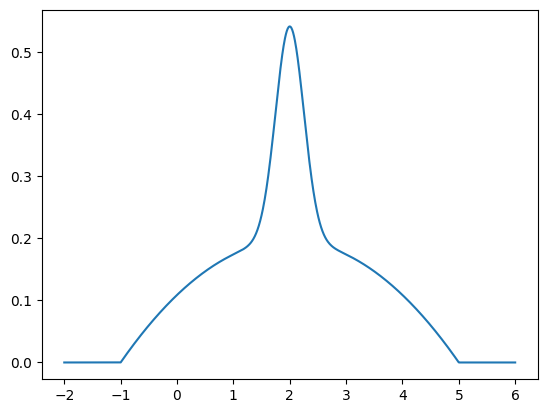

In [130]:
def theta(x,a,b):
    if type(x) == np.ndarray or type(x) == list:
        return np.array([1 if a <= i and b>= i else 0 for i in x])
    else: return 1 if a <= x and b>= x else 0

def parabola(x,a,b,c):
    return a*x**2 + b*x + c

area_para = crude_montecarlo(lambda x: -0.2*x**2+0.8*x+1,-1,5)[0]
area_gauss = crude_montecarlo(lambda x: 2*norm.pdf(x,loc=2,scale=0.25),-1,5)[0]
# area_tot = crude_montecarlo(lambda x: 2*norm.pdf(x,loc=2,scale=0.25),-1,5)[0]
area_tot = area_para + area_gauss

scale_para = area_para/area_tot
scale_gauss = area_gauss/area_tot

# PDF
pdf_parabola = lambda x: parabola(x,-0.2,0.8,1)/area_para #* theta(x,-1,5) # normalized
pdf_gauss = lambda x: norm.pdf(x,loc=2,scale=0.25) #* theta(x,-1,5)

def pdf(x):
    val = scale_para*pdf_parabola(x) + scale_gauss*pdf_gauss(x)
    if type(val) == np.ndarray:
        return np.array([i if i>0 else 0 for i in val])
    return val if val>=0 else 0

# print(crude_montecarlo(pdf,-1,5)[0])

X = np.linspace(-2,6,1000)
plt.plot(X,pdf(X))
plt.show()

In [148]:
def rand_uniform(min,max,size=1):
    if size==1: return np.float64(np.random.rand()*(max-min) + min)
    return np.random.rand(size)*(max-min) + min

def rand_TAC(pdf,xmin,xmax,ymax,size=1):
    l = np.empty(size,dtype=np.float64)
    for i in range(size):
        randX = rand_uniform(xmin,xmax,size=1)
        while pdf(randX) < rand_uniform(0,ymax,size=1):
            randX = rand_uniform(xmin,xmax,size=1)
        l[i] = randX
    return l[0] if size == 1 else l

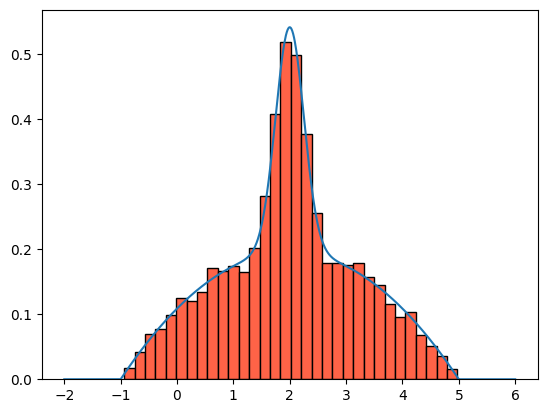

In [133]:
N = 10000
data = rand_TAC(pdf,-1,5,1,size=N)
plt.hist(data, bins = sturges(N), edgecolor='black', color='tomato',density=True) #,**hist_style(len(data))
plt.plot(X,pdf(X))
plt.show()

# __Parameters estimation:__

In [154]:
from iminuit.cost import ExtendedBinnedNLL
from iminuit import Minuit

bin_edges = np.linspace(np.min(data),np.max(data),sturges(N))
bin_content = np.array([len(data[(data>i)*(data<=g)]) for i,g in zip(bin_edges[:-1],bin_edges[1:])])
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])

In [161]:
def g_total(x, N_background, a, b, c, N_signal, n, mu, sigma):
    return  N_background * (a * x**3 * (1./3.) + b * x**2 * 0.5 + c * x) + \
            N_signal * n * norm.cdf(x, loc = mu, scale = sigma)


my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, g_total)

# ---------------- BACKGROUND ------------------------------------------
my_minuit = Minuit(my_cost_func, 
                   N_background = N, a=-0.1, b=1., c=1., 
                   N_signal = N, n=1., mu=np.mean(data), sigma=np.std(data)) # arbitrary starting values with the right signs
my_minuit.limits['N_background', 'b', 'c', 'N_signal', 'n', 'mu', 'sigma'] = (0, None)
my_minuit.limits['a'] = (None, 0)

my_minuit.values['N_signal'] = 0
my_minuit.fixed['N_signal', 'n', 'mu', 'sigma'] = True
my_cost_func.mask = (bin_centres < 1.5) | (2.5 < bin_centres) # mask guessed looking at a preliminary histogram
my_minuit.migrad()
#print(my_minuit.valid)
#display(my_minuit)
# ----------------------------------------------------------------------

# ---------- fix BKG and search for signal -----------------------------
my_cost_func.mask = None
my_minuit.fixed = False
my_minuit.fixed['N_background', 'a', 'b', 'c'] = True
my_minuit.values['N_signal'] = N - my_minuit.values['N_background']
my_minuit.migrad()
#print(my_minuit.valid)
#display(my_minuit)
#------------------------------------------------------------------------
#------ all starting estimation are done, now search for the bests: -----
my_minuit.fixed = False
my_minuit.migrad()
#print(my_minuit.valid)
display(my_minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.29 (χ²/ndof = 1.1)      │              Nfcn = 598              │
│ EDM = 1.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_background │    982    │    21     │            │            │    0    │         │       │
│ 1 │ a            │ -220.9e-3 │  0.7e-3   │            │            │         │    0    │       │
│ 2 │ b            │   0.883   │   0.005   │            │            │    0    │         │       │
│ 3 │ c            │   1.096   │   0.024   │            │            │    0    │         │       │
│ 4 │ N_signal     │  5.29e3   │  0.15e3   │            │            │    0    │         │       │
│ 5 │ n            │   0.425   │   0.012   │            │            │    0    │         │       │
│ 6 │ mu           │   1.992   │   0.010   │            │            │    0    │         │       │
│ 7 │ sigma        │   0.260   │   0.009   │            │            │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│              │ N_background            a            b            c     N_signal            n           mu        sigma │
├──────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ N_background │          445   -4.4436e-3    42.713e-3    -351.5e-3       -1.0e3    -77.88e-3     -0.21e-3    -65.22e-3 │
│            a │   -4.4436e-3      5.6e-07      -0.6e-6      -0.1e-6   12.6380e-3       1.0e-6      -0.2e-6       0.9e-6 │
│            b │    42.713e-3      -0.6e-6     2.22e-05    -0.082e-3   -72.911e-3    -0.006e-3    -0.002e-3    -0.005e-3 │
│            c │    -351.5e-3      -0.1e-6    -0.082e-3     0.000586     448.2e-3      0.04e-3      0.01e-3      0.03e-3 │
│     N_signal │       -1.0e3   12.6380e-3   -72.911e-3     448.2e-3     2.14e+04   -226.90e-3      0.36e-3    431.28e-3 │
│            n │    -77.88e-3       1.0e-6    -0.006e-3      0.04e-3   -226.90e-3     0.000139            0      0.03e-3 │
│           mu │     -0.21e-3      -0.2e-6    -0.002e-3      0.01e-3      0.36e-3            0     9.18e-05            0 │
│        sigma │    -65.22e-3       0.9e-6    -0.005e-3      0.03e-3    431.28e-3      0.03e-3            0      8.7e-05 │
└──────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────┘